In [1]:
%matplotlib inline
#Codes by Shucheng Yang
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pycbc.psd

from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
from pycbc import filter

from scipy.interpolate import interp1d #导入scipy库
import os
import time

def file2series(path):
    with open(path, 'r') as f:
        datafile = f.readlines()

    datafile = [np.fromstring(item.replace("D","e").replace('\n','').strip(), dtype= float, sep =' ') for item in datafile]
    datafile = np.array(datafile)
    ans = {}
    
    ans['timeVec'] = datafile[:,0]
    ans['n'] = len(ans['timeVec'])
    ans['sampIntrvl'] = ans['timeVec'][1]-ans['timeVec'][0]
    
    ans['hp'] = TimeSeries( datafile[:,5], delta_t=ans['sampIntrvl'], dtype = float,copy=True)
    ans['hc'] = TimeSeries( datafile[:,6], delta_t=ans['sampIntrvl'], dtype = float,copy=True)    
    return ans


#绘制波形图
def plotwave(hp,hc):
    plt.figure(figsize=(8,8/1.5))
    plt.plot(hp.sample_times, hp, label = '$h_{+}$')
    plt.plot(hc.sample_times, hc, label = '$h_{\\times}$')
    # plt.xlim(40,40.5)
    # plt.ylim(- 2e-22,2e-22)
    plt.xlabel("Time / s")
    plt.ylabel("$Strain$")
    plt.legend()
    plt.tight_layout()
    plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
    plt.show()


def stdf(h, f_max, freqIntrvl):
    #interp1d
    hf = h.to_frequencyseries()    
    freqVec = hf.sample_frequencies
    hf_value = np.array(hf)
    fit=interp1d(freqVec, hf_value,fill_value = "extrapolate")  
    #
    stdFreqVec = np.arange(0, f_max, freqIntrvl)
    hf_value_std = fit(stdFreqVec)
    stdf_series = pycbc.types.frequencyseries.FrequencySeries(hf_value_std, delta_f=freqIntrvl, epoch='', copy=True)
    return stdf_series

def overlap_match_func(hf1, hf2, psd, f_min, f_max):
    roverlap = filter.matchedfilter.overlap(hf1, hf2, psd=psd, low_frequency_cutoff=f_min , high_frequency_cutoff=f_max, normalized=True)  
    amplitude1 = filter.matchedfilter.sigmasq(hf1, psd=psd, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max )
    amplitude2 = filter.matchedfilter.sigmasq(hf2, psd=psd, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max )
    rmatch,nn =filter.matchedfilter.match(hf1, hf2, psd=psd, low_frequency_cutoff=f_min , high_frequency_cutoff=f_max,v1_norm=True ,v2_norm=True)
    rmatch = rmatch / np.sqrt(amplitude1 * amplitude2)
    return roverlap, rmatch

def compare_multi(filepath1, dirpath2, filename2, parse_file_name_func):
    #filepath1, 被比较的波形文件的路径
    #dirpath2, 不同参数波形文件的文件夹路径
    #filename2, 不同参数波形文件的文件名
    #parse_file_name_func， 从文件名提取参数的函数 
    
    #filepath1 波形导入
    ans1 = file2series(path1)
    hp1 = ans1["hp"]
    hc1 = ans1["hc"]
    timeVec1 = ans1["timeVec"]
    n1 = ans1["n"]
    sampIntrvl1 = ans1["sampIntrvl"]

    #filename2 提取参数
    a, nu = parse_file_name_func(filename2)
    
    #filepath1 波形导入
    ans2 = file2series( dirpath2 + filename2)
    hp2 = ans2["hp"]
    hc2 = ans2["hc"]
    timeVec2 = ans2["timeVec"]
    n2 = ans2["n"]
    sampIntrvl2 = ans2["sampIntrvl"]
    assert sampIntrvl1 == sampIntrvl2 
    sampIntrvl = sampIntrvl1
    n_min = min(n1,n2)          #采样点数(Sampling Number), 有时也称为信号长度(Length of Signal) 2^16为2的幂时，快速傅里叶变化效率最高
                                #n =  duration * sampFreqint = (duration / sampIntrvl)
    sampFreq = 1/sampIntrvl  #采样频率(Sampling frequency)，单位时间样本点个数，应大于 2f（即Nyquist频率)
    #duration = n/sampFreq     #信号持续时间(duration of signal) 2^16, 0.75d, 2^25 ,1.06yr
    #sampIntrvl = 1.0/sampFreq #采样周期(Sampling period)，隔多少时间取样一次，或步长
    

    freqIntrvl = 1.0 / (n_min * sampIntrvl) #傅里叶变换 频率分辨率(Frequency Interval) #freqIntrvl=1/duration=1/(n*sampIntrvl)=sampFreq/n  

    f_min = 20                              #低于此频率的psd将被设置为0
    f_max = sampFreq/2                      #信号模式的最大频率

    #示例，psd参见， https://dcc.ligo.org/LIGO-T1800044/public
    psd = pycbc.psd.from_string('aLIGOaLIGODesignSensitivityT1800044', n_min , freqIntrvl, f_min)


    hpf1 = stdf(hp1, f_max, freqIntrvl)
    hpf2 = stdf(hp2, f_max, freqIntrvl)

    hcf1 = stdf(hc1, f_max, freqIntrvl)
    hcf2 = stdf(hc2, f_max, freqIntrvl)

    overlap_hp, match_hp = overlap_match_func(hpf1, hpf2, psd, f_min, f_max)
    overlap_hc, match_hc = overlap_match_func(hcf1, hcf2, psd, f_min, f_max)

    return a, nu, match_hp, match_hc, overlap_hp, overlap_hc

In [2]:
#下面用于[文件名解析参数]的函数要根据实际情况进行修改################################################################################
def parse_file_name_func(filename):
    ##下面要根据实际情况修改
    anu = filename.replace("hbh60_NS14_a","").replace("_f20Hz_fisco.dat","").split("_nu")    
    a = float("0." + anu[0]) 
    nu = float("0.0" +anu[1])
    return a, nu

path1 = "/home/ysc/Desktop/nw5/heco60_NS14_a60s50_R9_nu250_f20Hz_fisco.dat"  #被比较的波形文件的路径
dirpath2 = "/home/ysc/Desktop/data/"                                          #不同参数波形文件的文件夹路径
##################################################################################################################################################

In [3]:
#将dirpath2下的文件的文件名转换成一个列表 file_name_list
file_name_list = os.listdir(dirpath2)
anslist = []


#计时
time0 = time.time()
for item in file_name_list:
    try:
        ans = compare_multi(path1, dirpath2, item, parse_file_name_func)
        print(ans)
        anslist.append(ans)
    except Exception:
        print(item) #如果打印文件名，则说明出错了，请查看上面一个代码框排错    
timet = time.time()
print("cost %4.2f s"%(timet-time0))


#排序, 转换为numpy序列
anslist = sorted(anslist)
ansarray = np.array(anslist)

#输出到文件 读取用np.loadtxt
np.savetxt("a_nu_match_hp_hc_overlap_hp_hc.data",ansarray, fmt='%s')

#结果分别存储给a,nu等，用于作图
a = ansarray[:,0]
nu = ansarray[:,1]
hp_match = ansarray[:,2]
hc_match = ansarray[:,3]
hp_overlap = ansarray[:,4]
hc_overlap = ansarray[:,5]

(0.59, 0.013, 0.12119046422362557, 0.12137455068170741, -0.059139567578239766, -0.061378184440501964)
(0.62, 0.0385, 0.21758513311907823, 0.21642386906921335, 0.1395709874566834, 0.13349575330638405)
(0.61, 0.022, 0.27683064249145795, 0.27926320857158576, -0.09130047480361635, -0.09238766204931068)
(0.7, 0.04, 0.24974500538211972, 0.2488102462344809, -0.15306255686672718, -0.1626028922270148)
(0.69, 0.0265, 0.645094790660162, 0.6446543924124662, -0.0010565426256887828, 0.0018073549291134062)
(0.54, 0.0115, 0.12340787520824789, 0.12211039291814481, 0.04646890718742447, 0.041670460808053755)
(0.7, 0.0115, 0.09133345495604435, 0.09109470211042893, -0.0021031648400363016, -0.006336742257936639)
(0.55, 0.013, 0.13762201675329327, 0.1381079551241598, 0.026494820232602582, 0.027286490240252096)
(0.56, 0.01, 0.10364326233499592, 0.10365185686918144, 0.06777752507493015, 0.06689683207390637)
(0.62, 0.0205, 0.20995020230593536, 0.20860740038053652, -0.069151663649318, -0.07245478686025933)
(0.59

(0.63, 0.0235, 0.2954175334065528, 0.29564647277279116, 0.004052149892296597, 0.006168111650780272)
(0.61, 0.0265, 0.5596963272593274, 0.561388193176305, -0.10782458582577985, -0.11145817164650387)
(0.59, 0.0145, 0.13790660885678374, 0.13825393431771213, 0.0347934276648615, 0.03688127930673523)
(0.61, 0.04, 0.19592966519049165, 0.19896969364257755, 0.12897413466175645, 0.12126974319295987)
(0.57, 0.0175, 0.20036487692945035, 0.2003290160474027, 0.03874246208838217, 0.03288437218356917)
(0.58, 0.0175, 0.18387723335349265, 0.18603721852245209, -0.12320734071035692, -0.12339898429908543)
(0.59, 0.025, 0.8789318140975965, 0.8847616657236804, 0.5012227099814291, 0.49719531239494036)
(0.57, 0.0295, 0.26076611990504933, 0.2672223311713446, 0.08650176668698951, 0.07919105944294753)
(0.64, 0.04, 0.21107254886636376, 0.21452934373447272, 0.19165071647714993, 0.1858044554891873)
(0.69, 0.028, 0.6587916506613273, 0.6591108302417218, 0.20753347142111925, 0.21133881616261793)
(0.6, 0.0205, 0.2302121

(0.67, 0.028, 0.6258519183628705, 0.6219238153294123, -0.02507020613499677, -0.025884353059695258)
(0.63, 0.0325, 0.2850742589246618, 0.2875156859805481, -0.1785704937513198, -0.17582654851913296)
(0.7, 0.0295, 0.48061904980714015, 0.4775669796332186, -0.1685570111369463, -0.17557736831269805)
(0.55, 0.037, 0.18694245203990717, 0.18437963339205304, 0.0025829855406823577, 0.003477316986051838)
(0.61, 0.0145, 0.1281849324838181, 0.12825813481456777, -0.006523760802678137, -0.012140362447929525)
(0.7, 0.034, 0.3194896631775744, 0.32012271878970117, -0.17813481105108844, -0.18626410858590534)
(0.6, 0.019, 0.2001810226509272, 0.20057779306674567, -0.09378995125053112, -0.09479344769149922)
(0.56, 0.0175, 0.21088735519614232, 0.20829219857694284, 0.06666727947940543, 0.06647380295570648)
(0.62, 0.0355, 0.2283276077644259, 0.2250477131506118, -0.09209821135814858, -0.09259472944319701)
(0.57, 0.04, 0.17766071204909037, 0.18443239013551405, 0.058667245060841956, 0.05016870769807087)
(0.67, 0.0

(0.57, 0.034, 0.204944118741721, 0.20586137960036746, -0.06659777048465501, -0.0633925227852117)
(0.66, 0.028, 0.5721145384871937, 0.5683850258645995, -0.054027716336889214, -0.0526652749196323)
(0.67, 0.0295, 0.5065388783913105, 0.5036541440809216, -0.23642712866341842, -0.2342653133561097)
(0.62, 0.0265, 0.5913857544364877, 0.5891550759382774, -0.00046286241686786605, 0.002742630843704419)
(0.5, 0.01, 0.12410152899545672, 0.12558924897741833, -0.1058379585730369, -0.1048663290382201)
(0.5, 0.0295, 0.2049754225192429, 0.2027058750808217, -0.013709211282731833, -0.015376886941214947)
(0.53, 0.04, 0.1715447895915043, 0.17111053710766186, 0.017081735935704074, 0.010492326550085454)
(0.56, 0.0385, 0.18193898793572325, 0.17927564057498202, -0.011198099540061682, -0.009373447355998288)
(0.56, 0.0265, 0.3222713588803461, 0.32749512801205904, 0.03489755150255936, 0.02846020201334188)
(0.65, 0.0175, 0.14231840541574967, 0.14314883348001442, -0.021858807413095493, -0.022656742273136656)
(0.7, 0

(0.6, 0.0265, 0.47385108892752537, 0.47177146529337205, -0.10344839271815154, -0.1031397497355688)
(0.53, 0.025, 0.4264845543168566, 0.43409488503263144, 0.006380510385845417, -0.0013022453805672633)
(0.58, 0.0265, 0.3749988702731077, 0.3788376498189537, 0.09433475063693927, 0.08783104811066927)
(0.62, 0.022, 0.2503447013392989, 0.2511684045484377, 0.07428577433842733, 0.07166207404984475)
(0.55, 0.019, 0.26728216946250277, 0.26694763307739217, 0.03453762640769317, 0.032000227440781716)
(0.62, 0.0145, 0.12402852417884659, 0.1252821781167428, -0.038991813454161306, -0.04232784510014911)
(0.54, 0.037, 0.17616737120051928, 0.1832600776940787, 0.06030485750995179, 0.05191522213503763)
(0.61, 0.034, 0.24232663853314626, 0.2405402172315186, 0.12411998239191284, 0.11862130619750527)
(0.63, 0.037, 0.22148675117668826, 0.2270270895634433, 0.01320358924954631, 0.007732159524654984)
(0.53, 0.031, 0.20406603331938697, 0.21103162606139353, 0.05882181328268024, 0.0509548789136993)
(0.69, 0.0235, 0.2

(0.64, 0.0295, 0.4126320622085741, 0.4120332622837592, 0.312463219937546, 0.316038401952483)
(0.55, 0.01, 0.10882285644217302, 0.10889921942874473, 0.08296288305452072, 0.0794336222919122)
(0.67, 0.016, 0.12457977289339811, 0.12398268960281394, 0.025137140755005775, 0.025054966913802035)
(0.59, 0.028, 0.3226134139030034, 0.3299596735652543, 0.15725666255785706, 0.15054272859544804)
(0.59, 0.037, 0.19508134466857482, 0.2022181300328618, 0.09728470068602768, 0.08912255651228232)
(0.54, 0.019, 0.28732649861932275, 0.28380244812917527, 0.19958920583883866, 0.19408859860823577)
(0.51, 0.016, 0.2324432154364541, 0.2362062559038737, -0.21090517428656108, -0.21196800356126125)
(0.57, 0.013, 0.12949048148715023, 0.12874106751211006, -0.08183754523646987, -0.08303108903810358)
(0.58, 0.016, 0.16257627780083797, 0.16334053860317235, -0.09917049001106373, -0.1006158152330093)
(0.7, 0.019, 0.15535788242503376, 0.15304996779974483, -0.01632220082166932, -0.020028374538103196)
(0.69, 0.0355, 0.323328

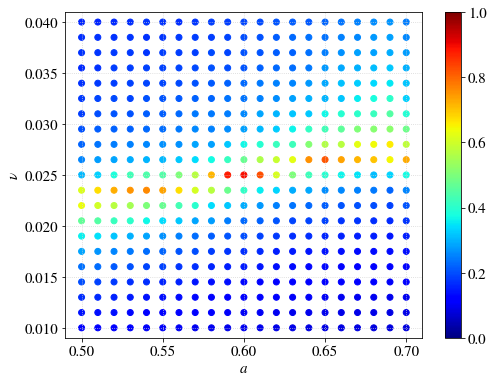

In [4]:
#绘图字体参数设置
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

x = a
y = nu
z = hp_match

cmap = matplotlib.cm.get_cmap('jet')#viridis
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
colors = [cmap(normalize(value)) for value in z]



fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(x, y, color=colors)
ax.set_xlabel("$a$")
ax.set_ylabel("$\\nu$")
ax.set_xlim([0.49,0.71])
ax.set_ylim([0.01-0.001,0.04 + 0.001])
#ax.set_title("hp_match")
plt.xticks([0.5,0.55,0.6,0.65,0.7])
plt.yticks([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])

# Optionally add a colorbar
cax, item = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

ax.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.show()

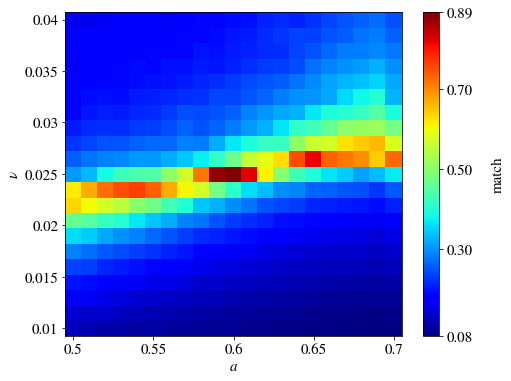

In [5]:
x = a
y = nu
z = hp_match


xstep = (max(x)-min(x))/21/2 #调整刻度，符合科学性
ystep = (max(y)-min(y))/21/2


plt.figure(figsize=(7.32,5.55))
plt.hist2d(x,y, bins=[21,21], weights = z, cmap=plt.cm.jet)
plt.xlabel("$a$")
plt.ylabel("$\\nu$")
plt.xlim([0.50,0.70])
plt.ylim([0.01, 0.04])
plt.xticks(np.linspace(0.5+xstep, 0.7-xstep,5),[0.5,0.55,0.6,0.65,0.7])
plt.yticks(np.linspace(0.01+ystep, 0.04-ystep,7),[0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])

#add a colorbar
cbar =plt.colorbar()
cbar.ax.text(3.5, 0.45, 'match', rotation=90)
cbar.set_ticks([min(z), 0.3, 0.5, 0.7,max(z)])
cbar.set_ticklabels([round(min(z),2), "0.30", "0.50", "0.70",round(max(z),2)])

#plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.tight_layout()
plt.savefig('hp_match.pdf', format = 'pdf', dpi = 300)     #保存图像
plt.show()